## Signal Prediction

Pseudo features:

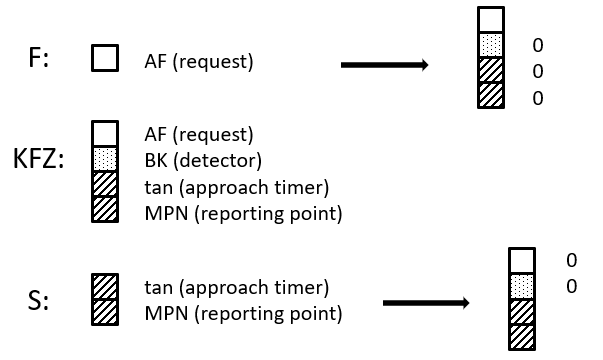

# Introduction

This notebook builds GNN-LSTM model with Keras layer, reference: https://keras.io/examples/timeseries/timeseries_traffic_forecasting/
author:Arash khodadadi



**Problem definition:** given 120 historical timestamps with signal classes, predict change in signal for the next 30 steps ahead.

This model is trained for L249, including signals and requests of buses (public transport prioritization).

**Dataset description:**

* Total number of instances: 86400
* Training set: 70%
* Validation set: 20%
* Test set: 10%
* Timestamp - a value representing seconds


Problem settings: predict such tagret virables as **'K01R', 'K02', 'K03'** based on such features as 'timestamp/Uhrzeit' (TX).


*   **BK02**: Bemessung für K02 (Interner Detektor **D21/22**)
*   **ANF_K03**: Anforderung für K03
*   **ZYK**: cycle time

K01R status: R->S->G->A->R (A: Achtung; S: Start; G: Grün; R: Rot), only Green is 1, other status will be set to 0

**Class 1:** green (the vehicle is free to pass the intersection)

**Class 0:** red, yellow, yellow_green (the vehicle must stop)

This notebook consists of the implementation of the following **models**:

* Hybrid model (1basic GCN (A^-1 * X) + 1LSTM)
* activation: Relu (GCN) + tanh (LSTM)


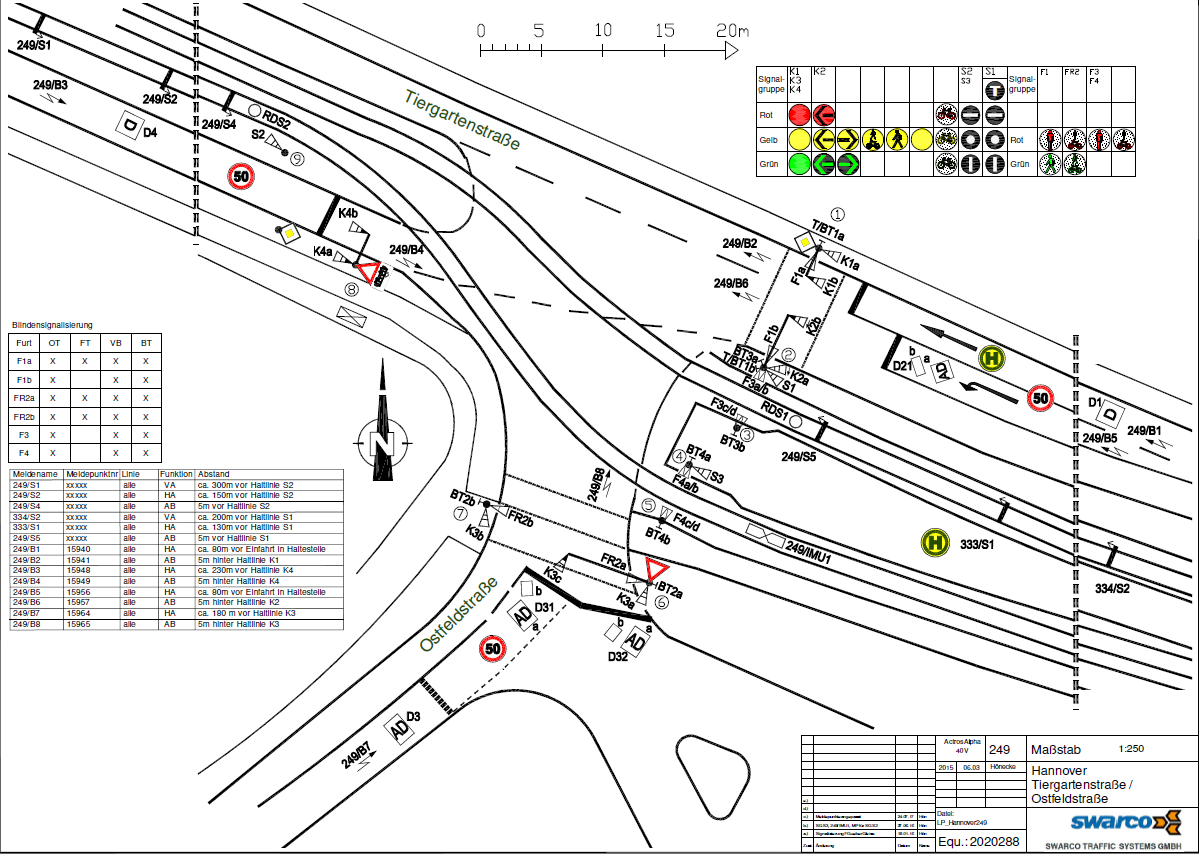

conflict matrix:

**S3, F3, F4 need to be deleted.**

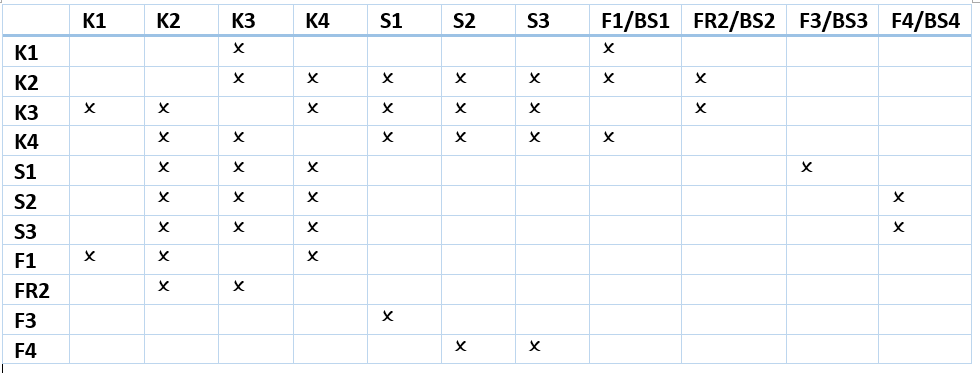

## Adjacency matrix:

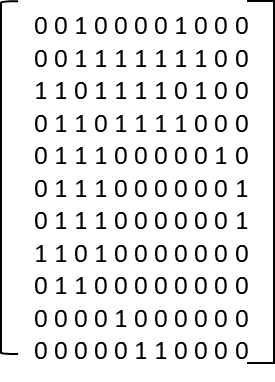

In [ ]:
import networkx as nx
import numpy as np

# using conflict matrix to create an adjacency matrix
# delete all-0 features: S3, F3, F4 to get 8 features
adj_matrix = np.array([[0, 0, 1, 0, 0, 0, 1, 0],
             [0, 0, 1, 1, 1, 1, 1, 1],
             [1, 1, 0, 1, 1, 1, 0, 1],
             [0, 1, 1, 0, 1, 1, 1, 0],
             [0, 1, 1, 1, 0, 0, 0, 0],
             [0, 1, 1, 1, 0, 0, 0, 0],
             [1, 1, 0, 1, 0, 0, 0, 0],
             [0, 1, 1, 0, 0, 0, 0, 0]])

# Creating an undirected graph from the adjacency matrix
G = nx.Graph(adj_matrix)
num_nodes=adj_matrix.shape[0]
node_indices, neighbor_indices = np.where(adj_matrix == 1)

# graph info
print("No. of nodes:", num_nodes)
print("Nodes:", G.nodes())
print("Edges:", G.edges())
print("No. of edges:", len(G.edges()))
print("edges[0]: ",node_indices.tolist())
print("edges[1]: ",neighbor_indices.tolist())

No. of nodes: 8
Nodes: [0, 1, 2, 3, 4, 5, 6, 7]
Edges: [(0, 2), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 3), (2, 4), (2, 5), (2, 7), (3, 4), (3, 5), (3, 6)]
No. of edges: 15
edges[0]:  [0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7]
edges[1]:  [2, 6, 2, 3, 4, 5, 6, 7, 0, 1, 3, 4, 5, 7, 1, 2, 4, 5, 6, 1, 2, 3, 1, 2, 3, 0, 1, 3, 1, 2]


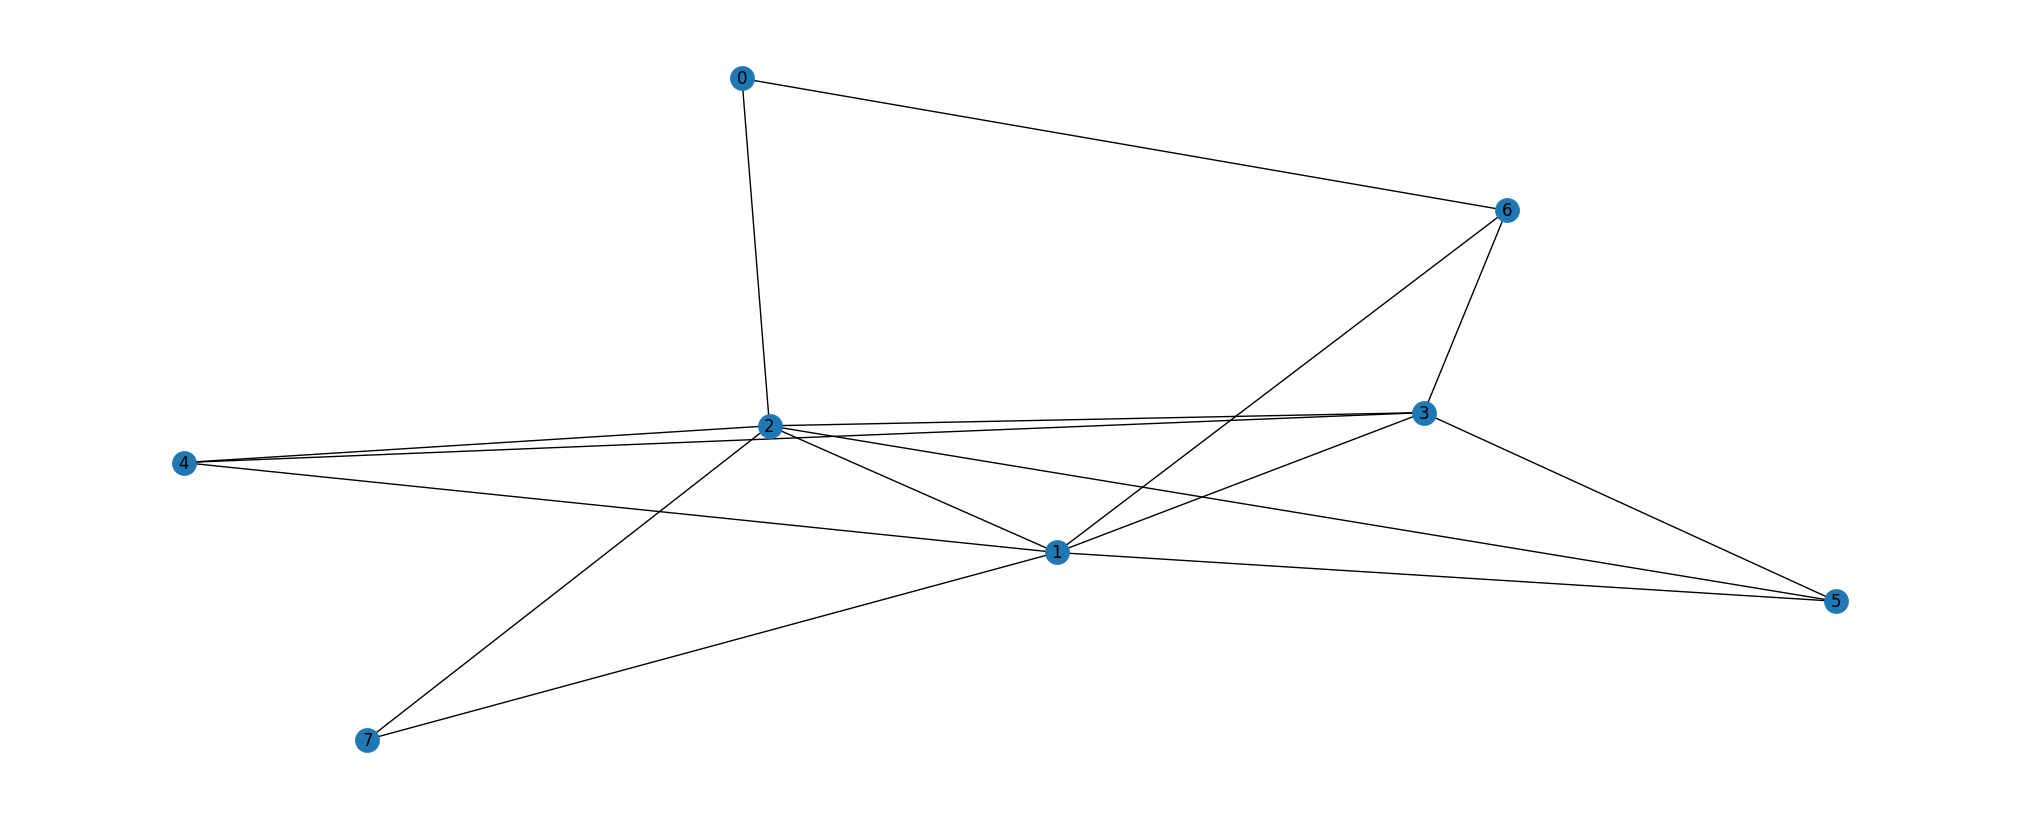

In [ ]:
# draw the graph（Matplotlib library）
nx.draw(G, with_labels=True)

# Data Preparation

In [ ]:
# set a target variable 'K1 (Node0)', 'K2', 'K3', 'K4'
trg = 'K1'
# including Bus

In [ ]:
# pip install anfis

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import requests
import typing
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from tensorflow import feature_column
from tensorflow.keras import layers
import keras.optimizers
mpl.style.use('bmh')

mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.grid'] = False

# for downloading a file from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# loading data from google drive
# my file id s_ana "18gJSwrb5vNk_V2W5ylqZFgsYH53jZ5ly"

# downloaded = drive.CreateFile({'id':"18gJSwrb5vNk_V2W5ylqZFgsYH53jZ5ly"})   # replace the id with id of file you want to access
# downloaded.GetContentFile('data.csv')        # replace the file name with your file

# init_df = pd.read_csv('data.csv', low_memory=False)
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/249/2021-12-14-L0249(processed).CSV', low_memory=False)

# basic statistical analysis
# df.describe().transpose()
# data preparation / cleaning
df=df.drop(columns=['Uhrzeit'])
df

,K1,K2,K3,K4,S1,S1T,S2,S3,F1,FR2,...,MPN_15956,MPN_15957,MPN_15940,MPN_15941,MPN_4,MPN_5,MPN_6,MPN_1,MPN_2,MPN_3
0,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
1,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
2,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
3,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
4,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
86396,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
86397,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
86398,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0


## Data Transform

In [ ]:

# add time frame (as index)
df['timestamp'] = df.index
col_name="timestamp"
first_col = df.pop(col_name)
df.insert(0, col_name, first_col)

# re-transforming the problem to binary classification
# red, yellow and yellow_red attibutes = 0, green = 1

df.replace('G', '1', inplace=True, regex=True)
df.replace('R', '0', inplace=True, regex=True)
df.replace('A', '0', inplace=True, regex=True)
# acoustic signal for Blinde Lampe
df.replace('a', '1', inplace=True, regex=True)
df.replace('S', '0', inplace=True, regex=True)
df.replace('D', '0', inplace=True, regex=True)

df['AF1'][df.AF1>0]=1
df['AFBT2'][df.AFBT2>0]=1
df['AFBT03'][df.AFBT03>0]=1
df['AFBT01'][df.AFBT01>0]=1
df['AFBT04'][df.AFBT04>0]=1
df['AFK03'][df.AFK03>0]=1
df['AFK02'][df.AFK02>0]=1


df = df.astype(int)

# df = df.rename(columns={' D2': 'D2', ' D3': 'D3', ' D4': 'D4', ' K1': 'K1',' K2':'K2', ' K3':'K3', ' K4':'K4'})
# save a copy of initial df
init_df = df
df

<ipython-input-37-9ea0beec8535>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AF1'][df.AF1>0]=1
<ipython-input-37-9ea0beec8535>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AFBT2'][df.AFBT2>0]=1
<ipython-input-37-9ea0beec8535>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AFBT03'][df.AFBT03>0]=1
<ipython-input-37-9ea0beec8535>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

,timestamp,K1,K2,K3,K4,S1,S1T,S2,S3,F1,...,MPN_15956,MPN_15957,MPN_15940,MPN_15941,MPN_4,MPN_5,MPN_6,MPN_1,MPN_2,MPN_3
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,86395,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86396,86396,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86397,86397,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86398,86398,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Correlation Heatmap

<Figure size 800x800 with 0 Axes>

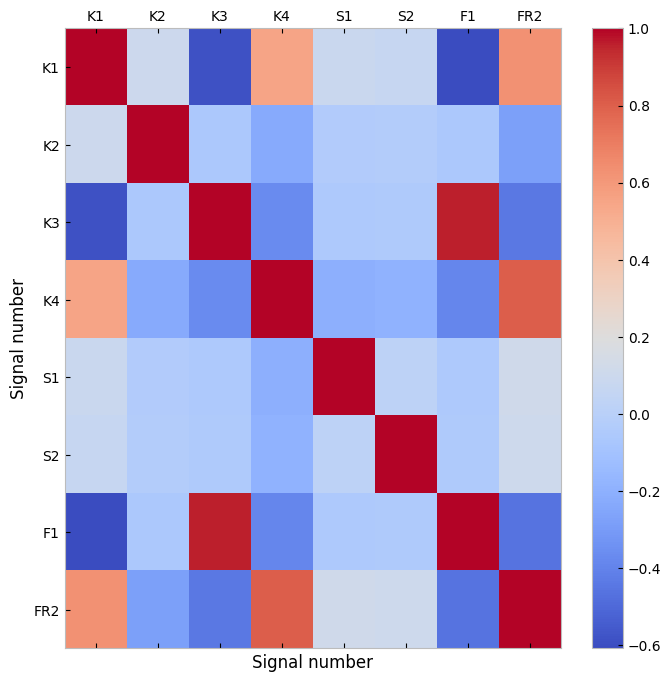

In [ ]:
df_plot = df[['K1','K2','K3','K4','S1','S2','F1','FR2']]
df_plot_array = df_plot.to_numpy()

#draw correlation heatmap of time series of different signals
# Calculate the correlation matrix
corr_matrix = np.corrcoef(df_plot_array.T)

# Handle the case where the standard deviation is zero
stddev = np.std(df_plot_array, axis=0)
stddev_is_zero = stddev == 0
corr_matrix[:, stddev_is_zero] = 0
corr_matrix[stddev_is_zero, :] = 0

# Draw the correlation heatmap
plt.figure(figsize=(8, 8))
#plt.matshow(corr_matrix, 0)
#add colorbar to explain corelation degree
im = plt.matshow(np.corrcoef(df_plot_array.T), cmap='coolwarm', aspect='auto')
plt.colorbar(im)

# Define signal names for the legend
signal_names = df_plot.columns.tolist()

# Add legend with column names
#plt.legend(signal_names, loc='best')

# Customize x and y axis ticks
plt.xticks(range(len(signal_names)), signal_names)  # Set ticks as numbers
plt.yticks(range(len(signal_names)), signal_names)

# Set x-axis tick labels
#plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 45, ha='right')  # Rotate and align x-axis labels

plt.xlabel("Signal number")
plt.ylabel("Signal number")
plt.show()

Divide data:

In [ ]:
df['OR_f1'] = df['AF1'] | df['AFBT01']
df_k1 = df[['BK1', 'tanK10', 'MPN_15940', 'MPN_15941', 'AFK02', 'BK2', 'AFK03', 'BK3', 'tanK40', 'MPN_15948', 'MPN_15949', 'tan10', 'tan11', 'MPN_1', 'MPN_2', 'MPN_3', 'tan20', 'tan21', 'MPN_4', 'MPN_5', 'MPN_6', 'OR_f1','AFBT2']]
#df_k1 = df[['K1','K2','K3','K4','S1','S2','F1','FR2']]
# 补充 特征 [AF, BK, tan_VA, tan_HA, MPN_VA, MPN_HA, MPN_AB]
num_features = 7
# insert '0' as appendix features column
df_k1.insert(0, 'AFK01', 0)
df_k1.insert(df_k1.columns.get_loc('BK1') + 1, 'tan_VA_K01', 0)
df_k1.insert(df_k1.columns.get_loc('tanK10') + 1, 'MPN_VA_K01', 0)

df_k1.insert(df_k1.columns.get_loc('BK2') + 1, 'tan_VA_K02', 0)
df_k1.insert(df_k1.columns.get_loc('BK2') + 2, 'tan_HA_K02', 0)
df_k1.insert(df_k1.columns.get_loc('BK2') + 3, 'MPN_VA_K02', 0)
df_k1.insert(df_k1.columns.get_loc('BK2') + 4, 'MPN_HA_K02', 0)
df_k1.insert(df_k1.columns.get_loc('BK2') + 5, 'MPN_AB_K02', 0)

df_k1.insert(df_k1.columns.get_loc('BK3') + 1, 'tan_VA_K03', 0)
df_k1.insert(df_k1.columns.get_loc('BK3') + 2, 'tan_HA_K03', 0)
df_k1.insert(df_k1.columns.get_loc('BK3') + 3, 'MPN_VA_K03', 0)
df_k1.insert(df_k1.columns.get_loc('BK3') + 4, 'MPN_HA_K03', 0)
df_k1.insert(df_k1.columns.get_loc('BK3') + 5, 'MPN_AB_K03', 0)

df_k1.insert(df_k1.columns.get_loc('tanK40') - 3, 'AF_K04', 0)
df_k1.insert(df_k1.columns.get_loc('tanK40') - 2, 'BK_K04', 0)
df_k1.insert(df_k1.columns.get_loc('tanK40') - 1, 'tan_VA_K04', 0)
df_k1.insert(df_k1.columns.get_loc('tanK40') + 1, 'MPN_VA_K04', 0)

df_k1.insert(df_k1.columns.get_loc('tan10') - 2, 'AF_s1', 0)
df_k1.insert(df_k1.columns.get_loc('tan10') - 1, 'BK_s1', 0)

df_k1.insert(df_k1.columns.get_loc('tan20') - 2, 'AF_s2', 0)
df_k1.insert(df_k1.columns.get_loc('tan20') - 1, 'BK_s2', 0)

df_k1.insert(df_k1.columns.get_loc('OR_f1') + 1, 'BK_F1', 0)
df_k1.insert(df_k1.columns.get_loc('OR_f1') + 2, 'tan_VA_F1', 0)
df_k1.insert(df_k1.columns.get_loc('OR_f1') + 3, 'tan_HA_F1', 0)
df_k1.insert(df_k1.columns.get_loc('OR_f1') + 4, 'MPN_VA_F1', 0)
df_k1.insert(df_k1.columns.get_loc('OR_f1') + 5, 'MPN_HA_F1', 0)
df_k1.insert(df_k1.columns.get_loc('OR_f1') + 6, 'MPN_AB_F1', 0)

df_k1.insert(df_k1.columns.get_loc('AFBT2') + 1, 'BK_F2', 0)
df_k1.insert(df_k1.columns.get_loc('AFBT2') + 2, 'tan_VA_F2', 0)
df_k1.insert(df_k1.columns.get_loc('AFBT2') + 3, 'tan_HA_F2', 0)
df_k1.insert(df_k1.columns.get_loc('AFBT2') + 4, 'MPN_VA_F2', 0)
df_k1.insert(df_k1.columns.get_loc('AFBT2') + 5, 'MPN_HA_F2', 0)
df_k1.insert(df_k1.columns.get_loc('AFBT2') + 6, 'MPN_AB_F2', 0)

df_k1

,AFK01,BK1,tan_VA_K01,tanK10,MPN_VA_K01,MPN_15940,MPN_15941,AFK02,BK2,tan_VA_K02,...,MPN_VA_F1,MPN_HA_F1,MPN_AB_F1,AFBT2,BK_F2,tan_VA_F2,tan_HA_F2,MPN_VA_F2,MPN_HA_F2,MPN_AB_F2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# trg = 'K1', why to add target in features matrix X??
#df_k1 = new_df
# set target variable
df_k1['target'] = df[trg]
date_time = pd.to_datetime(df.pop('timestamp'))

df = df_k1

column_indices = {name: i for i, name in enumerate(df.columns)}

# Normalize the data
# Check if any column is all zeros
all_zeros = (df == 0).all()

# Normalize the data while preserving all-zero columns
df_max = df.max()
df_min = df.min()

# Normalize only non-zero columns
df_normal = df.copy()
for column in df.columns:
    if not all_zeros[column]:
        df_normal[column] = (df[column] - df_min[column]) / (df_max[column] - df_min[column])

# Restore all-zero columns
df_normal.loc[:, all_zeros] = df.loc[:, all_zeros]
df=df_normal

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]


test_df

<ipython-input-41-ad9e0da0393d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k1['target'] = df[trg]


,AFK01,BK1,tan_VA_K01,tanK10,MPN_VA_K01,MPN_15940,MPN_15941,AFK02,BK2,tan_VA_K02,...,MPN_HA_F1,MPN_AB_F1,AFBT2,BK_F2,tan_VA_F2,tan_HA_F2,MPN_VA_F2,MPN_HA_F2,MPN_AB_F2,target
77760,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,...,0,0,0.0,0,0,0,0,0,0,1.0
77761,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,...,0,0,0.0,0,0,0,0,0,0,1.0
77762,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,...,0,0,0.0,0,0,0,0,0,0,1.0
77763,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,...,0,0,0.0,0,0,0,0,0,0,1.0
77764,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,...,0,0,0.0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,...,0,0,0.0,0,0,0,0,0,0,1.0
86396,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,...,0,0,0.0,0,0,0,0,0,0,1.0
86397,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,...,0,0,0.0,0,0,0,0,0,0,1.0
86398,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,...,0,0,0.0,0,0,0,0,0,0,1.0


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AFK01,86400.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
BK1,86400.0,0.104711,0.306182,0.0,0.0,0.0,0.0,1.0
tan_VA_K01,86400.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
tanK10,86400.0,0.005219,0.047911,0.0,0.0,0.0,0.0,1.0
MPN_VA_K01,86400.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
MPN_15940,86400.0,0.000729,0.026993,0.0,0.0,0.0,0.0,1.0
MPN_15941,86400.0,0.000741,0.027207,0.0,0.0,0.0,0.0,1.0
AFK02,86400.0,0.105648,0.307389,0.0,0.0,0.0,0.0,1.0
BK2,86400.0,0.016921,0.128977,0.0,0.0,0.0,0.0,1.0
tan_VA_K02,86400.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


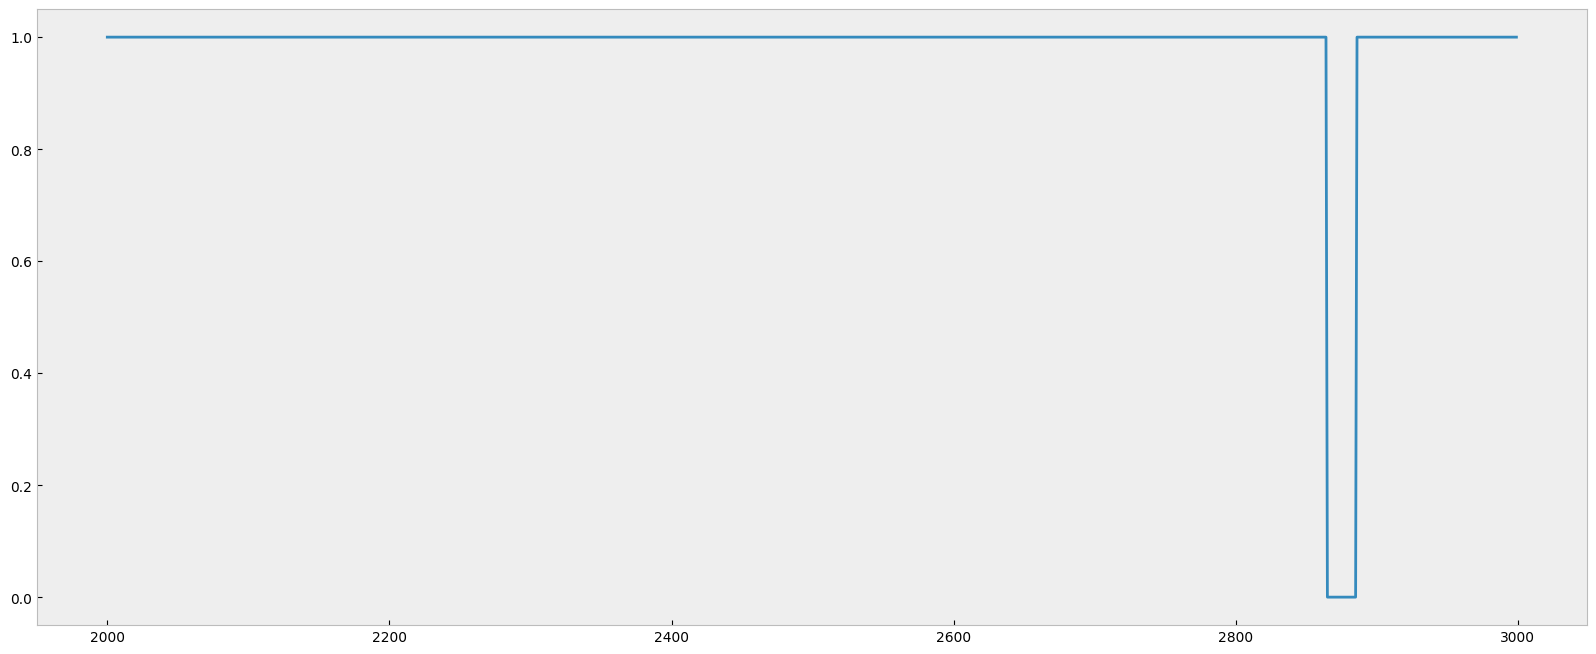

In [ ]:
plt.plot(train_df['target'][2000:3000])

## Time Window Generation

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        #f'Label column name(s): {self.label_columns}'
        ])

In [ ]:
def split_window(self, features):

  batch_size = tf.shape(features)[0]
  # [batch dimension; time dimension; feature columns]
  # :-1 to exclude last features, "targets" here
  inputs = features[:, self.input_slice, :-1]
  #
  # -1: only include the last feature "target"
  labels = features[:, self.labels_slice, -1:]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
  #print("transpose...")
  # Transpose the data
  #inputs = tf.transpose(inputs, perm=[0, 2, 1])
  #labels = tf.transpose(labels, perm=[0, 2, 1])

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  #need:(batch_size, input_seq_len, num_nodes, in_feat)
  #inputs.set_shape([None,  self.input_width, None])
  inputs = tf.reshape(inputs,[-1, self.input_width, 8, 7])

  #labels.set_shape([None,  self.label_width, None])
  labels = tf.reshape(labels, [-1, self.label_width, 1])
  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# modified shape for model training, can not be used temporarily
def plot(self, model=None, plot_col='target', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 6))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    marker='o', edgecolors='face', label='Labels', c='#4e8f18', s=84)
        if model is not None:
            # predictions = model.predict(inputs)
            # print(predictions)
            predictions = (model.predict(inputs) > 0.5).astype("int32")
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='*', edgecolors='face', label='Predictions',
                      c='#d1d41c', s=130)

        if n == 0:
            plt.legend()

    plt.xlabel('Time')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  #print("preprocess starts: ")
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
  #print("make_dataset ", tf.shape(ds)[0])

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
MAX_EPOCHS = 32
# patience = 5
def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                                    patience=patience,
                                                    mode='max')
  #print("compile")
  model.compile(optimizer=tf.optimizers.Adam(),
                loss=tf.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.metrics.BinaryAccuracy()])
  #print("fit")
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
OUT_STEPS = 30
#30
input_width= 120
multi_window = WindowGenerator(input_width=input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

#multi_window.plot()
multi_window

Total window size: 150
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149]

# Machine Learning Training

In [ ]:
multi_val_performance = {}
multi_performance = {}

## GCN LSTM Customlayer

In [ ]:
#!pip install tensorflow --upgrade
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import typing
import tensorflow as tf
import keras
from keras import layers

#from keras import ops

**Graph Convolution Layer**

Our implementation of the graph convolution layer is similar to the implementation in this Keras example. Note that in that example, the input to the layer is a 2D tensor with shape `(num_nodes, in_feat)`, whereas in our example, the input to the layer is a 4D tensor with shape `(num_nodes, batch_size, input_seq_length, in_feat)`. The graph convolution layer performs the following steps:

- The node representations are computed by `self.compute_nodes_representation()` by multiplying the input features with `self.weight`.
- The aggregation of neighbors’ messages is computed by `self.compute_aggregated_messages()`, which first aggregates the neighbors’ representations and then multiplies the result by `self.weight`.
- The final output of the layer is computed by `self.update()` by combining the node representations and the aggregated neighbor messages.

A Graph Convolutional Network (Graph Convolutional Network, GCN) is a deep learning model designed for graph-structured data. It performs convolution operations on graphs to learn node representations. Below, the forward propagation process of a GCN layer is described using mathematical formulas:

Given an input feature matrix $X$ with shape $(N, D_{\text{in}})$, where $N$ is the number of nodes and $D_{\text{in}}$ is the dimensionality of the input features. Suppose $A$ is the adjacency matrix of the graph, $D$ is the degree matrix, and $I$ is the identity matrix. The output of the graph convolution layer can be computed as follows:

1. **Linear Transformation**:

$$
Z = XW
$$

where $W$ is the weight matrix of the graph convolution layer with shape $(D_{\text{in}}, D_{\text{out}})$, and $D_{\text{out}}$ is the dimensionality of the output features.

2. **Neighborhood Aggregation**:

$$
\tilde{Z}_i = \sum_{j \in \mathcal{N}(i)} \frac{1}{\sqrt{d_i d_j}} Z_j
$$

where $\mathcal{N}(i)$ denotes the set of neighboring nodes of node $i$, and $d_i$ and $d_j$ are the degrees of nodes $i$ and $j$, respectively.

3. **Activation Function**:

$$
H = \text{Activation}(\tilde{Z})
$$

Here, $\text{Activation}$ can be any activation function, such as ReLU, sigmoid, or tanh.

In code, the implementation of the GCN layer follows these steps:

1. Apply a linear transformation by multiplying the input feature matrix with the weight matrix to obtain the node representation matrix.
2. Aggregate the features of each node’s neighbors to obtain the aggregated neighbor features.
3. Combine the node representations with the aggregated neighbor features and apply an activation function to obtain the final node representation matrix.

In this way, after one graph convolution layer, updated node representations are obtained.


In [ ]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        #graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="add",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        #self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = self.add_weight(
            name="weight",
            initializer=keras.initializers.GlorotUniform(),
            shape=(in_feat, out_feat),
            dtype="float32",
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                #self.graph_info.edges[0],
                node_indices.tolist(),
                num_segments=num_nodes, #self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features):
        neighbour_representations = tf.gather(features, neighbor_indices.tolist())#self.graph_info.edges[1]
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation, aggregated_messages):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")
        return self.activation(h)

    def call(self, features):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

**LSTM with Graph Convolution**

By applying the graph convolution layer to the input tensor, we obtain another tensor that contains node representations over time (another 4D tensor). For each time step, the representation of a node is informed by information from its neighbors.

However, to make accurate predictions, we not only need information from neighboring nodes, but also need to process this information over time. To this end, we can pass the tensor of each node to a recurrent layer. The `LSTMGC` layer below first applies a graph convolution layer to the input and then passes the result to an LSTM layer.


Assume the input feature matrix is $X$ with shape $(N, T_{\text{in}}, D_{\text{in}})$, where $N$ is the number of nodes, $T_{\text{in}}$ is the input sequence length, and $D_{\text{in}}$ is the dimensionality of the input features. Assume the output sequence length is $T_{\text{out}}$.

**Graph Convolutional Layer**:

The output of the graph convolutional layer, $Z_{\text{GCN}}$, can be computed as:

$Z_{\text{GCN}} = \text{GCN}(X)$

where $\text{GCN}(\cdot)$ denotes the forward propagation process of the graph convolutional layer, whose computation has been described in the previous formulas.

**LSTM Layer**:

The output of the graph convolutional layer $Z_{\text{GCN}}$ is fed into the LSTM layer to obtain the LSTM output $H_{\text{LSTM}}$:

$H_{\text{LSTM}} = \text{LSTM}(Z_{\text{GCN}})$

where $\text{LSTM}(\cdot)$ denotes the forward propagation process of the LSTM layer. The shape of $H_{\text{LSTM}}$ is $(N \times B, T_{\text{in}})$, where $B$ is the batch size.

**Dense Layer**:

The output of the LSTM layer $H_{\text{LSTM}}$ is passed to a fully connected (dense) layer to obtain the output $Y$:

$Y = \text{Dense}(H_{\text{LSTM}})$

where $\text{Dense}(\cdot)$ denotes the forward propagation process of the dense layer. The shape of $Y$ is $(N \times B, T_{\text{out}})$.

**Reshape**:

The output of the dense layer $Y$ is reshaped into a tensor with shape $(N, B, T_{\text{out}})$:

$Y_{\text{reshaped}} = \text{Reshape}(Y)$

where $\text{Reshape}(\cdot)$ denotes the reshaping operation.

**Output**:

The reshaped tensor $Y_{\text{reshaped}}$ is then transposed to obtain the final output tensor $Y_{\text{output}}$ with shape $(B, T_{\text{out}}, N)$:

$Y_{\text{output}} = \text{Transpose}(Y_{\text{reshaped}})$

where $\text{Transpose}(\cdot)$ denotes the transpose operation.

In this way, the forward propagation process of the entire hybrid model is completed.


In [ ]:
# AR_LSTM layer
class AR_LSTM(layers.Layer):
    def __init__(self, units, out_steps):
        super().__init__()
        self.units = units
        self.out_steps = out_steps
        self.num_features = 7
        self.lstm_cell = layers.LSTMCell(units)
        self.lstm_rnn = layers.RNN(self.lstm_cell, return_state=True)
        self.dense = layers.Dense(self.num_features)

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs):
        predictions = []
        prediction, state = self.warmup(inputs)
        predictions.append(prediction)
        for n in range(1, self.out_steps):
            x, state = self.lstm_cell(prediction, states=state, training=None)
            prediction = self.dense(x)
            predictions.append(prediction)
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [ ]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        #graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "add",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, **graph_conv_params) #graph_info

        self.arlstm = AR_LSTM(lstm_units, forecast_horizon)#num_features=7
        self.dense = layers.Dense(1) # 7->1
        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(
            gcn_out, (batch_size * num_nodes, input_seq_len, out_feat)
        )
        lstm_out = self.arlstm(
            gcn_out
        )  # ar lstm_out has shape: (batch_size * num_nodes, output_seq_len, num_features)
        print("lstm out: ", lstm_out.shape)
        # (None, 30, 7)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        print("dense_output: ", dense_output.shape)

        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        output=output[0:1, :, :]#K01
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes, 1)

**模型训练**

In [ ]:
# 补充 特征 [AF, BK, tan_VA, tan_HA, MPN_VA, MPN_HA, MPN_AB]
in_feat = 7
batch_size = 32
# epochs = 20
input_sequence_length = 120
forecast_horizon = 30
multi_horizon = True
out_feat = 7
lstm_units = 120
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "add",
    "activation": "relu"
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    #graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, num_nodes, in_feat))
outputs = st_gcn(inputs)

keras_gcn_lstm_model = keras.models.Model(inputs, outputs)

# train the model and to save
history = compile_and_fit(keras_gcn_lstm_model, multi_window)

lstm out:  (None, 30, 7)
dense_output:  (None, 30, 1)
Epoch 1/32
lstm out:  (None, 30, 7)
dense_output:  (None, 30, 1)
lstm out:  (None, 30, 7)
dense_output:  (None, 30, 1)
1886/1886 [==============================] - ETA: 0s - loss: 0.3614 - binary_accuracy: 0.8318lstm out:  (None, 30, 7)
dense_output:  (None, 30, 1)
1886/1886 [==============================] - 1099s 579ms/step - loss: 0.3614 - binary_accuracy: 0.8318 - val_loss: 0.4420 - val_binary_accuracy: 0.7904
Epoch 2/32
1886/1886 [==============================] - 1059s 561ms/step - loss: 0.3274 - binary_accuracy: 0.8488 - val_loss: 0.4307 - val_binary_accuracy: 0.8171
Epoch 3/32
1886/1886 [==============================] - 1094s 580ms/step - loss: 0.3078 - binary_accuracy: 0.8547 - val_loss: 0.4304 - val_binary_accuracy: 0.8120
Epoch 4/32
1886/1886 [==============================] - 1091s 579ms/step - loss: 0.3013 - binary_accuracy: 0.8572 - val_loss: 0.4196 - val_binary_accuracy: 0.8168
Epoch 5/32
1886/1886 [=================

In [ ]:
# after training, save the model
keras_gcn_lstm_model.save('/content/drive/MyDrive/Colab Notebooks/249/models/hetero_gcn_ar_lstm_model_1Day_norm')
IPython.display.clear_output()

multi_val_performance['GCN_LSTM_Keras'] = keras_gcn_lstm_model.evaluate(multi_window.val)
multi_performance['GCN_LSTM_Keras'] = keras_gcn_lstm_model.evaluate(multi_window.test, verbose=0)

536/536 [==============================] - 120s 224ms/step - loss: 0.5414 - binary_accuracy: 0.7796


In [ ]:
keras_gcn_lstm_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 8, 7)]       0         
                                                                 
 lstmgc_1 (LSTMGC)           (None, 30, 1)             62344     
                                                                 
Total params: 62344 (243.53 KB)
Trainable params: 62344 (243.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Performance


### Binary Accuracy

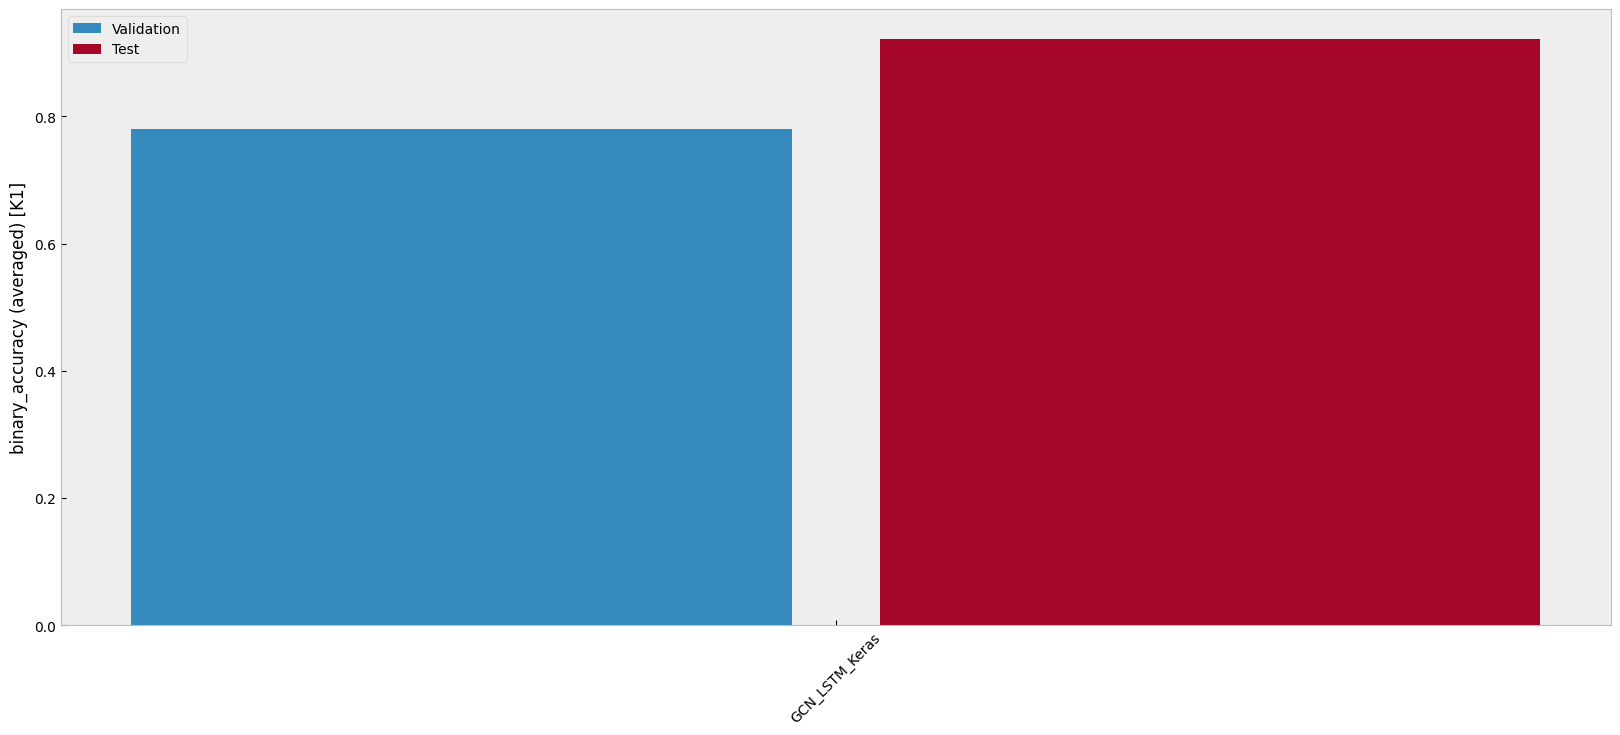

In [ ]:
# performance

x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'binary_accuracy'
metric_index = keras_gcn_lstm_model.metrics_names.index('binary_accuracy')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'binary_accuracy (averaged) ' + '['+ trg + ']')
_ = plt.legend()

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

GCN_LSTM_Keras: 0.9221


In [ ]:
print(multi_performance)

{'GCN_LSTM_Keras': [0.24354757368564606, 0.9221410751342773]}


In [ ]:
for name, value in multi_val_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

GCN_LSTM_Keras: 0.7796


### Basic Metrics
所有训练好的模型已经保存，不需要重复运行训练，只需要加载即可，此部分和训练部分代码可分开运行。

#### seq-2-step evaluation

In [ ]:
OUT_STEPS_1 = 1
input_width_1= 120
multi_window_1 = WindowGenerator(input_width=input_width_1,
                               label_width=OUT_STEPS_1,
                               shift=OUT_STEPS_1)

multi_window_1

Total window size: 121
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120]

In [ ]:
print(test_df.shape)

# 获取一个元素
sample_element = next(iter(multi_window_1.test))

# 输出形状
print("Shape of the sample element:", sample_element[0].shape)  # 输入的形状
print("Shape of the labels:", sample_element[1].shape)  # 标签的形状

print(len(list(iter(sample_element[0]))))

(8640, 57)
Shape of the sample element: (32, 120, 8, 7)
Shape of the labels: (32, 1, 1)
32


In [ ]:
check_it = iter(multi_window_1.test)
check_list=list(check_it)
check_features, check_labels = check_list[0]
print('iteration length:',len(check_list))
#print(check_list[0])
print('fist inputs size',check_features.shape)
print('fist labels size',check_labels.shape)
test_dataset_length = tf.data.experimental.cardinality(multi_window_1.test).numpy()
print("Test dataset length:", test_dataset_length)
print(check_features.shape[0])

iteration length: 267
fist inputs size (32, 120, 8, 7)
fist labels size (32, 1, 1)
Test dataset length: 267
32


将输出30s的模型，用于仅预测未来一个step, 来验证精确度如何。

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils.multiclass import type_of_target
from sklearn import metrics

# load models
keras_gcn_lstm_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/249/models/hetero_gcn_ar_lstm_model_1Day_norm')

# initiation
y_tests = []

predictions_gcn_lstm = []
y_probas_gcn_lstm =[]

i = 0
it = iter(multi_window_1.test)

# 280*30+120 = 8520 < 8640 (length of test set)

for i in range(267): #266
        # 获得下一个值:
        result = next(it)
        inputs, labels = result

        # GCN-LSTM-proba (float probability)
        y_proba_gcn_lstm = keras_gcn_lstm_model.predict(inputs)
        #(batch, 30, 1)
        #y_proba_gcn_lstm_reshape = tf.transpose(y_proba_gcn_lstm, [0,2,1])
        # GCN-LSTM-predictions (binary int)
        prediction_gcn_lstm = tf.cast(y_proba_gcn_lstm > 0.5, tf.int32)
        #reshape (32,1,1)->(32,1,1) num_nodes=11,batchsize=32
        #labels_reshape = tf.transpose(labels, [0, 2, 1])
        #prediction_gcn_lstm_reshape = tf.transpose(prediction_gcn_lstm, [0,2,1])

        # M: batch size
        M = inputs.shape[0]
        #print(inputs.shape)
        #print(labels.shape)
        for j in range(M):
          #batchsize 32,
          #(batch,1,1)
          y_test = labels[j, :]
          y_tests.extend(y_test)
          #读取 每个batch的，第一个 step 输出
          # -6- GCN-LSTM
          # each time outputs one value
          #(batch, 30, 1)
          predictions_gcn_lstm.extend(prediction_gcn_lstm[j,0])
          y_probas_gcn_lstm.extend(y_proba_gcn_lstm[j, 0])


# -6- GCN-LSTM
acc_gcn_lstm = metrics.accuracy_score(y_tests, predictions_gcn_lstm)
ppv_gcn_lstm = metrics.precision_score(y_tests, predictions_gcn_lstm)
tpr_gcn_lstm = metrics.recall_score(y_tests, predictions_gcn_lstm)
f1_gcn_lstm = metrics.f1_score(y_tests, predictions_gcn_lstm)
mcc_gcn_lstm = metrics.matthews_corrcoef(y_tests, predictions_gcn_lstm)
conf_gcn_lstm = metrics.confusion_matrix(y_tests, predictions_gcn_lstm)



print("-6- GCN-LSTM Model")
print(f"Accuracy (ACC):                {acc_gcn_lstm: .3f}")
print(f"Precision score (PPV):            {ppv_gcn_lstm: .3f}")
print(f"Recall score (TPR):             {tpr_gcn_lstm: .3f}")
print(f"F1 score:                   {f1_gcn_lstm: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_gcn_lstm: .3f}")
print("confusion matrix: ", conf_gcn_lstm)


1/1 [==============================] - 0s 403ms/step
-6- GCN-LSTM Model
Accuracy (ACC):                 0.975
Precision score (PPV):             0.984
Recall score (TPR):              0.988
F1 score:                    0.986
Matthew's correlation coefficient (MCC):   0.868
confusion matrix:  [[ 786  119]
 [  92 7523]]


##### ROC AUC Curve

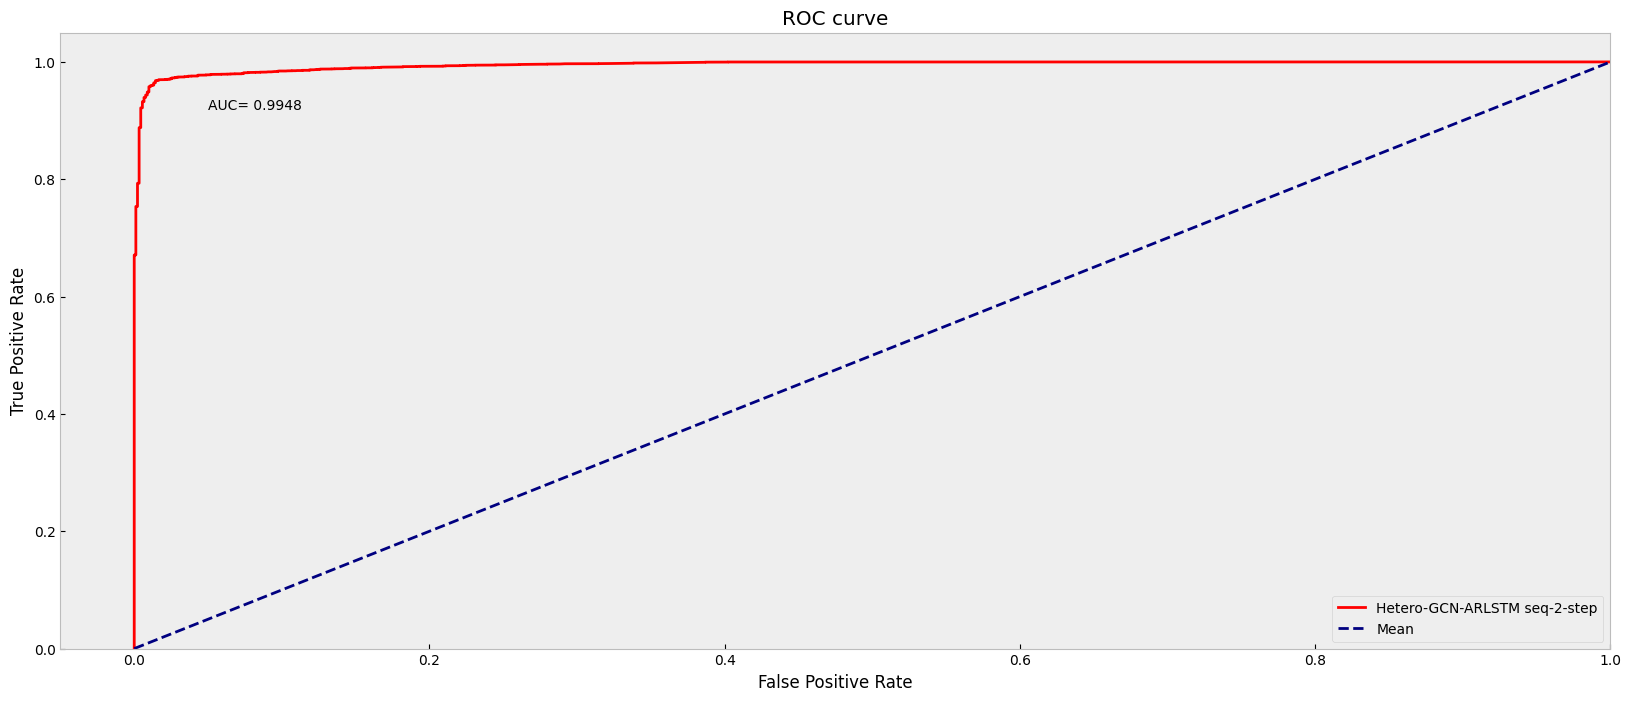

In [ ]:

FPRs_gcn_lstm_step, TPRs_gcn_lstm_step, _ = roc_curve(y_tests, y_probas_gcn_lstm)

# ROC-AUC
auc_score_gcn_lstm_step = metrics.roc_auc_score(y_tests, y_probas_gcn_lstm)

# Plot the ROC curve
plt.plot(FPRs_gcn_lstm_step, TPRs_gcn_lstm_step, color='red', lw=2, label='Hetero-GCN-ARLSTM seq-2-step')
plt.annotate(f'AUC={auc_score_gcn_lstm_step: .4f}', xy=(0.05,0.92) )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

#### seq-2-seq 30s evaluation

 Create multi_window_forTEST for Basic Metrics, recurrent calculate seq-2-point to output 30s as a seq-2-seq.

In [ ]:
OUT_STEPS_TEST = 30
input_width_TEST= 120
multi_window_forTEST = WindowGenerator(input_width=input_width_TEST,
                               label_width=OUT_STEPS_TEST,
                               shift=OUT_STEPS_TEST)

#multi_window.plot()
multi_window_forTEST

Total window size: 150
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149]

In [ ]:
print('iter: ', len(list(multi_window_forTEST.test)))

iter:  266


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils.multiclass import type_of_target
from sklearn import metrics

# load models
keras_gcn_lstm_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/249/models/hetero_gcn_ar_lstm_model_1Day_norm')

# initiation
y_tests_30 = []

predictions_gcn_lstm_30 = []
y_probas_gcn_lstm_30 =[]

i = 0
it = iter(multi_window_forTEST.test)

# 280*30+120 = 8520 < 8640 (length of test set)

for i in range(266): #266
        # 获得下一个值:
        result = next(it)
        inputs, labels = result

        # GCN-LSTM-proba (float probability)
        y_proba_gcn_lstm_30 = keras_gcn_lstm_model.predict(inputs)

        # GCN-LSTM-predictions (binary int)
        prediction_gcn_lstm_30 = tf.cast(keras_gcn_lstm_model.predict(inputs) > 0.5, tf.int32)

        y_test = labels[0, :]
        y_tests_30.extend(y_test)
        #用预测值更新inputs 调用predict() 共30次作为seq output.
        # -6- GCN-LSTM
        # each time outputs one value
        predictions_gcn_lstm_30.extend(prediction_gcn_lstm_30[0, :])
        y_probas_gcn_lstm_30.extend(y_proba_gcn_lstm_30[0, :])


# -6- GCN-LSTM
acc_gcn_lstm_30 = metrics.accuracy_score(y_tests_30, predictions_gcn_lstm_30)
ppv_gcn_lstm_30 = metrics.precision_score(y_tests_30, predictions_gcn_lstm_30)
tpr_gcn_lstm_30 = metrics.recall_score(y_tests_30, predictions_gcn_lstm_30)
f1_gcn_lstm_30 = metrics.f1_score(y_tests_30, predictions_gcn_lstm_30)
mcc_gcn_lstm_30 = metrics.matthews_corrcoef(y_tests_30, predictions_gcn_lstm_30)
conf_gcn_lstm_30 = metrics.confusion_matrix(y_tests_30, predictions_gcn_lstm_30)



print("-6- GCN-LSTM Model")
print(f"Accuracy (ACC):                {acc_gcn_lstm_30: .3f}")
print(f"Precision score (PPV):            {ppv_gcn_lstm_30: .3f}")
print(f"Recall score (TPR):             {tpr_gcn_lstm_30: .3f}")
print(f"F1 score:                   {f1_gcn_lstm_30: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_gcn_lstm_30: .3f}")
print("confusion matrix: ", conf_gcn_lstm_30)


1/1 [==============================] - 0s 117ms/step
-6- GCN-LSTM Model
Accuracy (ACC):                 0.931
Precision score (PPV):             0.957
Recall score (TPR):              0.966
F1 score:                    0.961
Matthew's correlation coefficient (MCC):   0.617
confusion matrix:  [[ 525  313]
 [ 241 6901]]


In [ ]:
print(y_proba_gcn_lstm.shape)
print(prediction_gcn_lstm.shape)
print('inputs_shape:', inputs.shape)
print('labels_shape:', labels.shape)
print('y_tests length:', len(y_tests))
print('y probas length:', len(y_probas_gcn_lstm))

(8, 30, 1)
(8, 30, 1)
inputs_shape: (11, 120, 8, 7)
labels_shape: (11, 30, 1)
y_tests length: 8520
y probas length: 8520


##### ROC AUC Curve


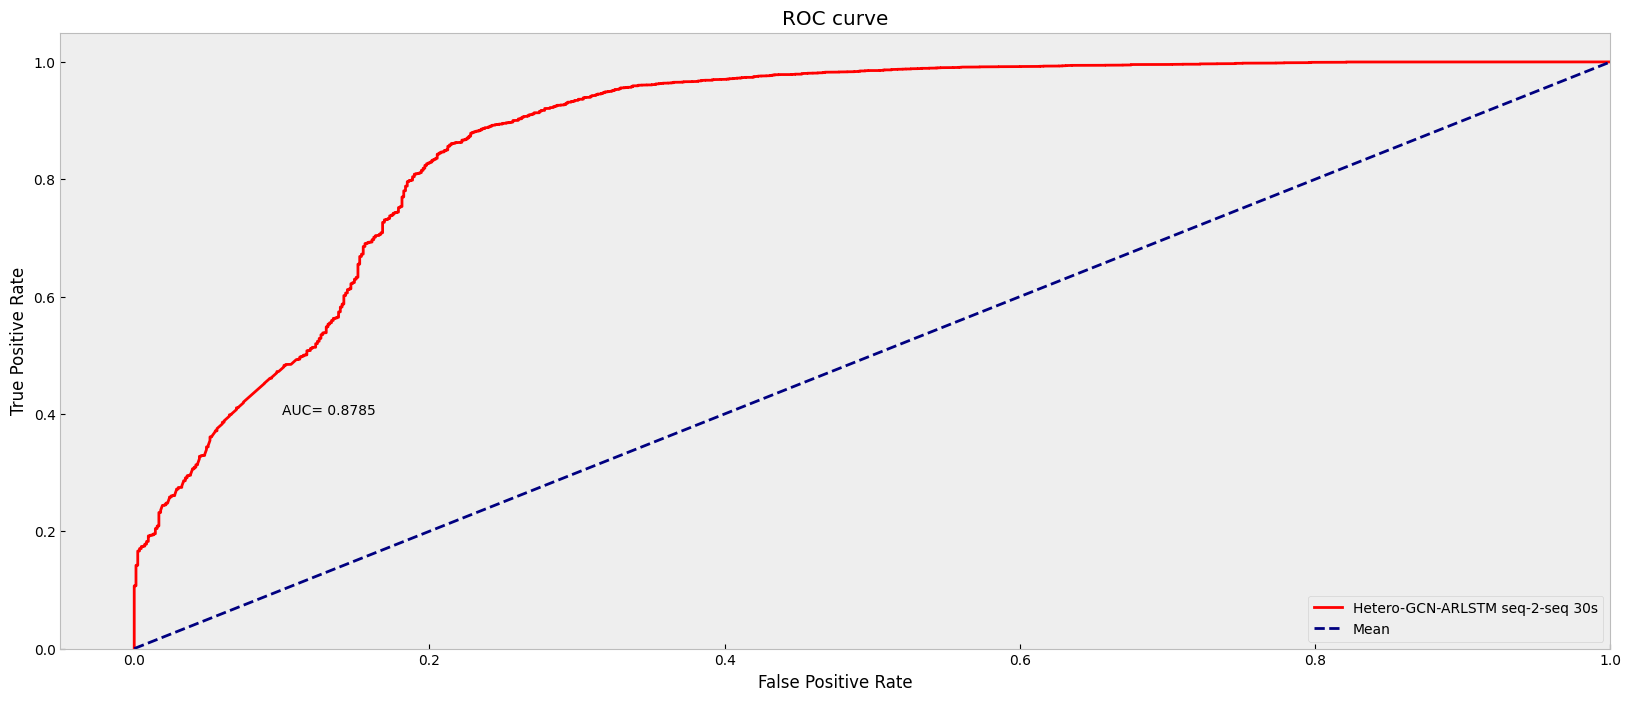

In [ ]:
'''
FPRs_dense, TPRs_dense, _ = roc_curve(y_tests, y_probas_dense)
FPRs_baseline, TPRs_baseline, _ = roc_curve(y_tests, y_probas_baseline)
FPRs_linear, TPRs_linear, _ = roc_curve(y_tests, y_probas_linear)
FPRs_cnn, TPRs_cnn, _ = roc_curve(y_tests, y_probas_cnn)
FPRs_lstm, TPRs_lstm, _ = roc_curve(y_tests, y_probas_lstm)
'''
FPRs_gcn_lstm_seq, TPRs_gcn_lstm_seq, _ = roc_curve(y_tests_30, y_probas_gcn_lstm_30)

# ROC-AUC
'''
auc_score_dense = metrics.roc_auc_score(y_tests, y_probas_dense)
auc_score_baseline = metrics.roc_auc_score(y_tests, y_probas_baseline)
auc_score_linear = metrics.roc_auc_score(y_tests, y_probas_linear)
auc_score_cnn = metrics.roc_auc_score(y_tests, y_probas_cnn)
auc_score_lstm = metrics.roc_auc_score(y_tests, y_probas_lstm)
'''
auc_score_gcn_lstm_seq = metrics.roc_auc_score(y_tests_30, y_probas_gcn_lstm_30)

# Plot the ROC curve
'''
plt.plot(FPRs_dense, TPRs_dense, color='red', lw=2, label='Dense')
plt.annotate(f'AUC={auc_score_dense: .4f}', xy=(0.34,0.6) ) # xy is added mannualy
plt.plot(FPRs_baseline, TPRs_baseline, color='yellow', lw=2, label='Baseline')
plt.annotate(f'AUC={auc_score_baseline: .4f}', xy=(0.45,0.87) )
plt.plot(FPRs_linear, TPRs_linear, color='black', lw=2, label='Linear')
plt.annotate(f'AUC={auc_score_linear: .4f}', xy=(0.21,0.7) )
plt.plot(FPRs_cnn, TPRs_cnn, color='green', lw=2, label='CNN')
plt.annotate(f'AUC={auc_score_cnn: .4f}', xy=(0.56,0.7) )
plt.plot(FPRs_lstm, TPRs_lstm, color='orange', lw=2, label='LSTM')
plt.annotate(f'AUC={auc_score_lstm: .4f}', xy=(0.2,0.86) )
'''
plt.plot(FPRs_gcn_lstm_seq, TPRs_gcn_lstm_seq, color='red', lw=2, label='Hetero-GCN-ARLSTM seq-2-seq 30s')
plt.annotate(f'AUC={auc_score_gcn_lstm_seq: .4f}', xy=(0.1,0.4) )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

####seq-2-seq 15s evaluation
只为 Basic Metrics 创建 multi_window_forTEST, recurrent calculate seq-2-step to output 15s as a seq-2-seq.

In [ ]:
OUT_STEPS_15 = 15
input_width_15= 120
multi_window_15 = WindowGenerator(input_width=input_width_15,
                               label_width=OUT_STEPS_15,
                               shift=OUT_STEPS_15)

multi_window_15

Total window size: 135
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134]

In [ ]:
print('iter: ', len(list(multi_window_15.test)))

iter:  266


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils.multiclass import type_of_target
from sklearn import metrics

# load models
keras_gcn_lstm_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/249/models/hetero_gcn_ar_lstm_model_1Day_norm')

# initiation
y_tests_15 = []

predictions_gcn_lstm_15 = []
y_probas_gcn_lstm_15 =[]

i = 0
it = iter(multi_window_15.test)

# 280*30+120 = 8520 < 8640 (length of test set)

for i in range(266): #266
        # 获得下一个值:
        result = next(it)
        inputs, labels = result

        # GCN-LSTM-proba (float probability)
        y_proba_gcn_lstm_15 = keras_gcn_lstm_model.predict(inputs)

        # GCN-LSTM-predictions (binary int)
        prediction_gcn_lstm_15 = tf.cast(keras_gcn_lstm_model.predict(inputs) > 0.5, tf.int32)

        #for j in range(M):
          #batchsize 32,
        y_test = labels[0, :15]
        y_tests_15.extend(y_test)
        #用预测值更新inputs 调用predict() 共30次作为seq output.
        # -6- GCN-LSTM
        # each time outputs one value
        predictions_gcn_lstm_15.extend(prediction_gcn_lstm_15[0, :15])
        y_probas_gcn_lstm_15.extend(y_proba_gcn_lstm_15[0, :15])

        y_test_1 = labels[1, :15]
        y_tests_15.extend(y_test_1)
        predictions_gcn_lstm_15.extend(prediction_gcn_lstm_15[1, :15])
        y_probas_gcn_lstm_15.extend(y_proba_gcn_lstm_15[1, :15])


# -6- GCN-LSTM
acc_gcn_lstm_15 = metrics.accuracy_score(y_tests_15, predictions_gcn_lstm_15)
ppv_gcn_lstm_15 = metrics.precision_score(y_tests_15, predictions_gcn_lstm_15)
tpr_gcn_lstm_15 = metrics.recall_score(y_tests_15, predictions_gcn_lstm_15)
f1_gcn_lstm_15 = metrics.f1_score(y_tests_15, predictions_gcn_lstm_15)
mcc_gcn_lstm_15 = metrics.matthews_corrcoef(y_tests_15, predictions_gcn_lstm_15)
conf_gcn_lstm_15 = metrics.confusion_matrix(y_tests_15, predictions_gcn_lstm_15)



print("-6- GCN-LSTM Model")
print(f"Accuracy (ACC):                {acc_gcn_lstm_15: .3f}")
print(f"Precision score (PPV):            {ppv_gcn_lstm_15: .3f}")
print(f"Recall score (TPR):             {tpr_gcn_lstm_15: .3f}")
print(f"F1 score:                   {f1_gcn_lstm_15: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_gcn_lstm_15: .3f}")
print("confusion matrix: ", conf_gcn_lstm_15)


1/1 [==============================] - 0s 181ms/step
-6- GCN-LSTM Model
Accuracy (ACC):                 0.963
Precision score (PPV):             0.975
Recall score (TPR):              0.983
F1 score:                    0.979
Matthew's correlation coefficient (MCC):   0.788
confusion matrix:  [[ 629  179]
 [ 120 7052]]


#####ROC AUC Curve

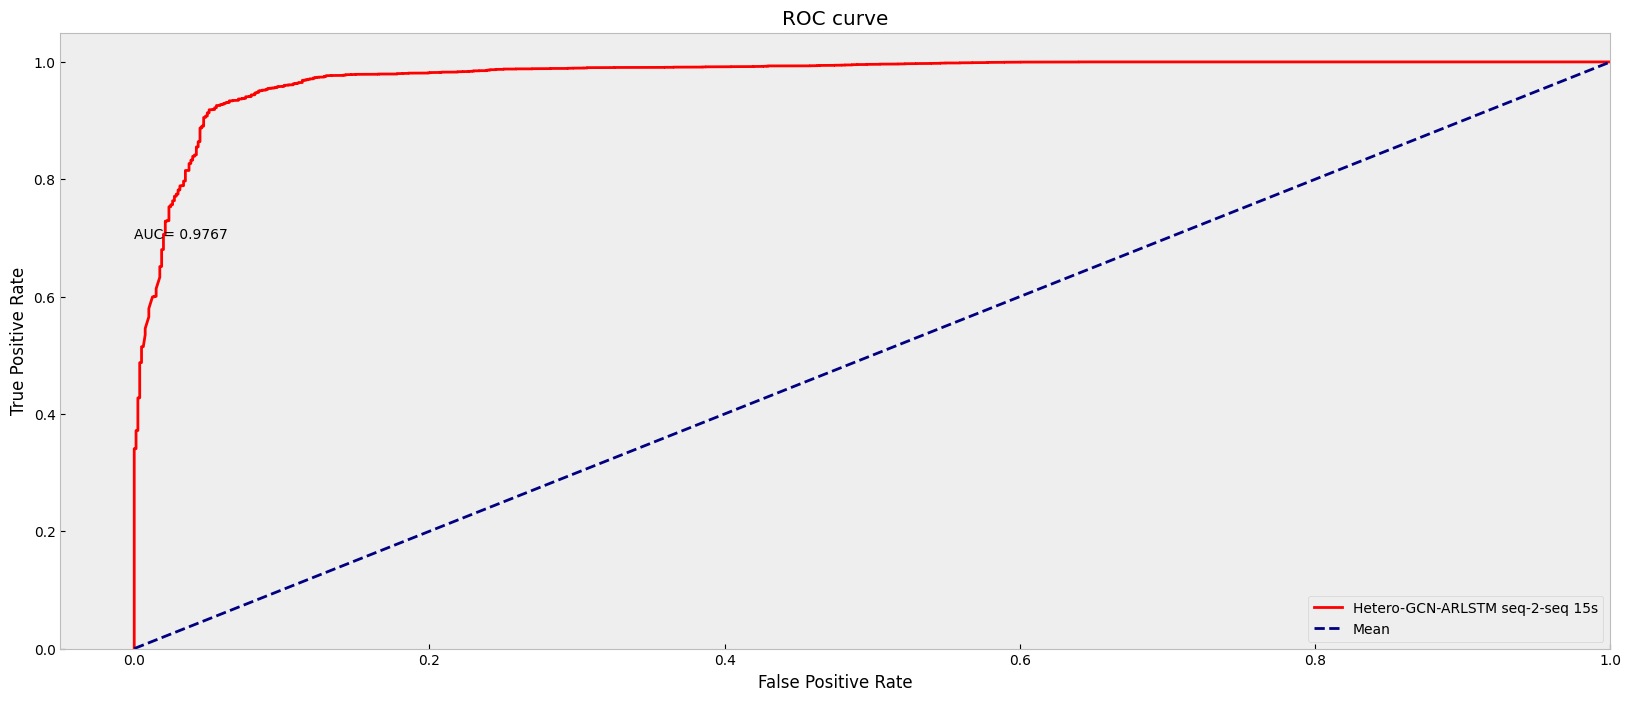

In [ ]:

FPRs_gcn_lstm_seq_15, TPRs_gcn_lstm_seq_15, _ = roc_curve(y_tests_15, y_probas_gcn_lstm_15)

# ROC-AUC
auc_score_gcn_lstm_seq_15 = metrics.roc_auc_score(y_tests_15, y_probas_gcn_lstm_15)

# Plot the ROC curve
plt.plot(FPRs_gcn_lstm_seq_15, TPRs_gcn_lstm_seq_15, color='red', lw=2, label='Hetero-GCN-ARLSTM seq-2-seq 15s')
plt.annotate(f'AUC={auc_score_gcn_lstm_seq_15: .4f}', xy=(0,0.7) )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
print('connecting')

connecting


#### ROC AUC Curve comparison

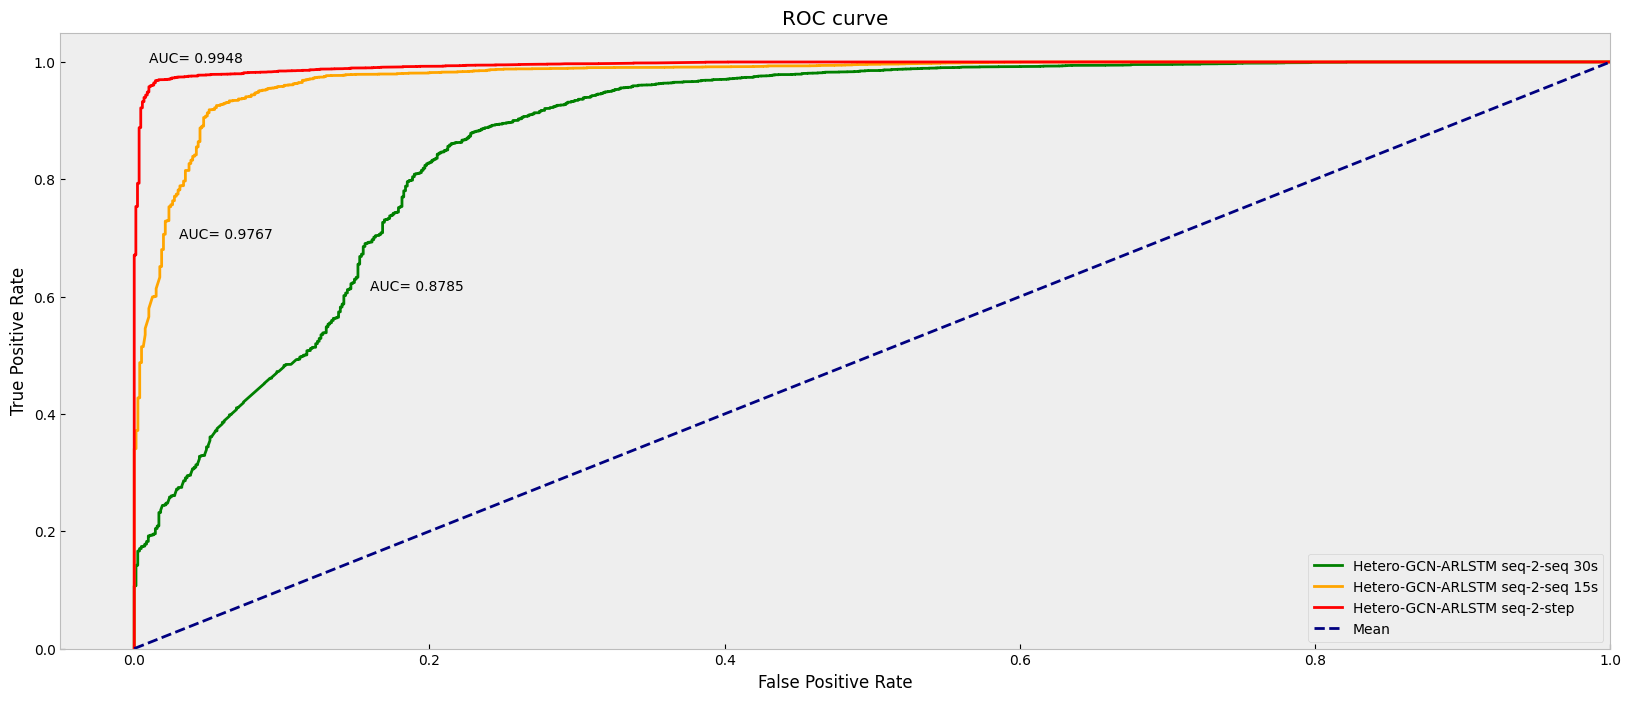

In [ ]:
#FPRs_gcn_lstm_step, TPRs_gcn_lstm_step, _ = roc_curve(y_tests, y_probas_gcn_lstm)
#FPRs_gcn_lstm, TPRs_gcn_lstm, _ = roc_curve(y_tests, y_probas_gcn_lstm)

# ROC-AUC
#auc_score_gcn_lstm_step = metrics.roc_auc_score(y_tests, y_probas_gcn_lstm)
#auc_score_gcn_lstm = metrics.roc_auc_score(y_tests, y_probas_gcn_lstm)

# Plot the ROC curve
plt.plot(FPRs_gcn_lstm_seq, TPRs_gcn_lstm_seq, color='green', lw=2, label='Hetero-GCN-ARLSTM seq-2-seq 30s')
plt.annotate(f'AUC={auc_score_gcn_lstm_seq: .4f}', xy=(0.16,0.61) )

plt.plot(FPRs_gcn_lstm_seq_15, TPRs_gcn_lstm_seq_15, color='orange', lw=2, label='Hetero-GCN-ARLSTM seq-2-seq 15s')
plt.annotate(f'AUC={auc_score_gcn_lstm_seq_15: .4f}', xy=(0.03,0.7) )

plt.plot(FPRs_gcn_lstm_step, TPRs_gcn_lstm_step, color='red', lw=2, label='Hetero-GCN-ARLSTM seq-2-step')
plt.annotate(f'AUC={auc_score_gcn_lstm_step: .4f}', xy=(0.01,1.0) )

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()